# Non supervised learning

## Autoencoders

Suppose we have only a set of unlabeled training examples $x_1,x_2,x_3, \dots $, where $x_i \in \Re^n$. 

An autoencoder neural network is an *unsupervised learning* algorithm that applies backpropagation and uses a loss function that is optimal when setting the target values to be equal to the inputs, $y_i=x_i$.

To build an autoencoder, you need three things: an **encoding function**, a **decoding function**, and a **distance function** between the amount of information loss between the compressed representation of your data and the decompressed representation.

<center>
<img src="images/autoencoder.jpg" alt="" style="width: 700px;"/>
Source: https://blog.keras.io/building-autoencoders-in-keras.html
</center>

Two practical applications of autoencoders are data denoising, and dimensionality reduction for data visualization. 

With appropriate dimensionality and sparsity constraints, autoencoders can learn data projections that are more interesting than PCA or other basic techniques.

We'll start simple, with a single fully-connected neural layer as encoder and as decoder:

In [1]:
# Source: Adapted from https://blog.keras.io/building-autoencoders-in-keras.html

from keras.layers import Input, Dense
from keras.models import Model

# this is the size of our encoded representations       
encoding_dim = 32  # 32 floats -> compression of factor 24.5, 
                   # assuming the input is 784 floats

input_img = Input(shape=(784,))

# encoded representation of the input
encoding_layer = Dense(encoding_dim, 
                       activation='relu')
encoded = encoding_layer(input_img)

# lossy reconstruction of the input
decoding_layer = Dense(784, 
                       activation='sigmoid')
decoded = decoding_layer(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

Using TensorFlow backend.


Let's also create a separate encoder model and a separate decoder model:

In [2]:
# this model maps an input to its encoded representation
encoding_model = Model(input_img, encoded)

# create a placeholder for an encoded input
# and create the decoder model
encoded_input = Input(shape=(encoding_dim,))
decoding_model = Model(encoded_input, decoding_layer(encoded_input))

autoencoder.compile(optimizer='adam', loss='mse')

Let's prepare our input data. 

In [4]:
from keras.datasets import mnist
import numpy as np
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print x_train.shape
print x_test.shape

autoencoder.fit(x_train, 
                x_train,
                nb_epoch=15,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

(60000, 784)
(10000, 784)
Train on 60000 samples, validate on 10000 samples
Epoch 1/15
60000/60000 [==============================] - 3s - loss: 0.0160 - val_loss: 0.0147
Epoch 2/15
60000/60000 [==============================] - 4s - loss: 0.0143 - val_loss: 0.0133
Epoch 3/15
60000/60000 [==============================] - 4s - loss: 0.0131 - val_loss: 0.0123
Epoch 4/15
60000/60000 [==============================] - 4s - loss: 0.0122 - val_loss: 0.0115
Epoch 5/15
60000/60000 [==============================] - 4s - loss: 0.0116 - val_loss: 0.0110
Epoch 6/15
60000/60000 [==============================] - 4s - loss: 0.0112 - val_loss: 0.0107
Epoch 7/15
60000/60000 [==============================] - 5s - loss: 0.0109 - val_loss: 0.0105
Epoch 8/15
60000/60000 [==============================] - 5s - loss: 0.0107 - val_loss: 0.0103
Epoch 9/15
60000/60000 [==============================] - 4s - loss: 0.0106 - val_loss: 0.0102
Epoch 10/15
60000/60000 [==============================] - 4s - loss:

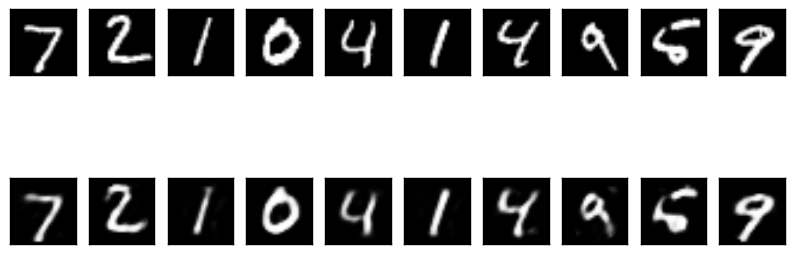

In [6]:
# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoding_model.predict(x_test)
decoded_imgs = decoding_model.predict(encoded_imgs)

import matplotlib.pyplot as plt
%matplotlib inline

n = 10  # how many digits we will display
plt.figure(figsize=(10, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### Adding depth and sparsity constraint on the encoded representations

In the previous example, the representations were only constrained by the size of the hidden layer (32). In such a situation, what typically happens is that the hidden layer is learning an approximation of PCA (principal component analysis). But another way to constrain the representations to be compact is to add a sparsity contraint on the activity of the hidden representations, so fewer units would "fire" at a given time. 

In Keras, this can be done by adding an ``activity_regularizer`` to our Dense layer:

In [15]:
#autoencoder.reset_states()
#encoder.reset_states()
#decoder.reset_states()

from keras import regularizers
from keras import optimizers
from keras.regularizers import l2, activity_l1
from keras.layers import Input, Dense
from keras.models import Model

input_img = Input(shape=(784,))
encoded = Dense(128, activation='relu')(input_img)
encoded = Dense(64, activation='relu')(encoded)
encoded = Dense(32, activation='relu')(encoded)
decoded = Dense(64, activation='relu')(encoded)
decoded = Dense(128, activation='relu')(decoded)
decoded = Dense(784, activation='sigmoid')(decoded)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', 
                    loss='binary_crossentropy',
                    activity_regularizer=regularizers.l1(10e-5))

autoencoder.fit(x_train, x_train,
                nb_epoch=100,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

/usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:1057: UserWarning: Expected no kwargs, you passed 1
kwargs passed to function are ignored with Tensorflow backend
  warnings.warn('\n'.join(msg))


Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 4s - loss: 0.3545 - val_loss: 0.2636
Epoch 2/100
60000/60000 [==============================] - 4s - loss: 0.2583 - val_loss: 0.2516
Epoch 3/100
60000/60000 [==============================] - 4s - loss: 0.2428 - val_loss: 0.2302
Epoch 4/100
60000/60000 [==============================] - 4s - loss: 0.2180 - val_loss: 0.2071
Epoch 5/100
60000/60000 [==============================] - 4s - loss: 0.2032 - val_loss: 0.1977
Epoch 6/100
60000/60000 [==============================] - 4s - loss: 0.1944 - val_loss: 0.1875
Epoch 7/100
60000/60000 [==============================] - 4s - loss: 0.1848 - val_loss: 0.1803
Epoch 8/100
60000/60000 [==============================] - 4s - loss: 0.1779 - val_loss: 0.1741
Epoch 9/100
60000/60000 [==============================] - 4s - loss: 0.1718 - val_loss: 0.1670
Epoch 10/100
60000/60000 [==============================] - 4s - loss: 0.1661 - val_lo

## Convolutional Autoencoders

Since our inputs are images, it makes sense to use convolutional neural networks (convnets) as encoders and decoders. 

In [16]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K

input_img = Input(shape=(28, 28, 1))  

x = Conv2D(16, 3, 3, activation='relu', border_mode='same')(input_img)
x = MaxPooling2D((2, 2), border_mode='same')(x)
x = Conv2D(8, 3, 3, activation='relu', border_mode='same')(x)
x = MaxPooling2D((2, 2), border_mode='same')(x)
x = Conv2D(8, 3, 3, activation='relu', border_mode='same')(x)
encoded = MaxPooling2D((2, 2), border_mode='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, 3, 3, activation='relu', border_mode='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, 3, 3, activation='relu', border_mode='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, 3, 3, activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, 3, 3, activation='sigmoid', border_mode='same')(x)

# at this point the representation is (28, 28, 1) i.e. 784-dimensional

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [17]:
from keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

In [18]:
from keras.callbacks import TensorBoard

autoencoder.fit(x_train, x_train,
                nb_epoch=50,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 67s - loss: 0.2324 - val_loss: 0.1744
Epoch 2/50
60000/60000 [==============================] - 65s - loss: 0.1585 - val_loss: 0.1449
Epoch 3/50
60000/60000 [==============================] - 67s - loss: 0.1427 - val_loss: 0.1370
Epoch 4/50
60000/60000 [==============================] - 68s - loss: 0.1338 - val_loss: 0.1284
Epoch 5/50
60000/60000 [==============================] - 69s - loss: 0.1276 - val_loss: 0.1256
Epoch 6/50
60000/60000 [==============================] - 90s - loss: 0.1234 - val_loss: 0.1198
Epoch 7/50
60000/60000 [==============================] - 91s - loss: 0.1202 - val_loss: 0.1174
Epoch 8/50
60000/60000 [==============================] - 68s - loss: 0.1179 - val_loss: 0.1173
Epoch 9/50
60000/60000 [==============================] - 68s - loss: 0.1161 - val_loss: 0.1137
Epoch 10/50
60000/60000 [==============================] - 67s - loss: 0.1143 - val_lo

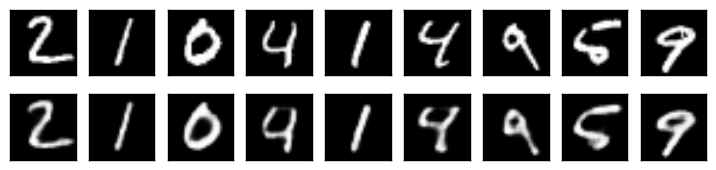

In [20]:
decoded_imgs = autoencoder.predict(x_test)

import matplotlib.pyplot as plt
n = 10
plt.figure(figsize=(10, 2))
for i in range(1,n):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Example: Image denoising

<center>
<img src="images/denoised_digits.png" alt="" style="width: 700px;"/> 
(Source: https://blog.keras.io/building-autoencoders-in-keras.html)
</center>

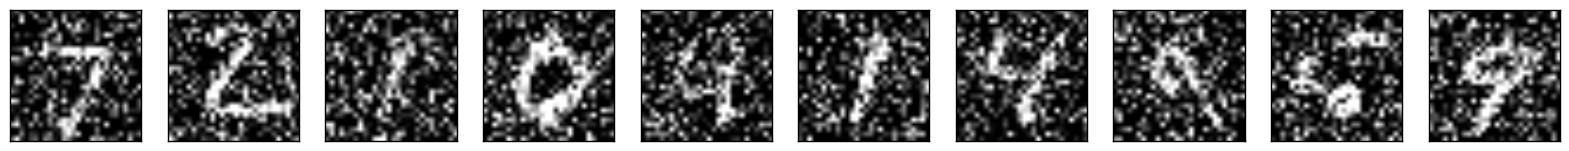

In [21]:
import matplotlib.pyplot as plt
import numpy as np
from keras.datasets import mnist
from keras.layers import Dense
from keras.models import Sequential

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 784))
x_test = np.reshape(x_test, (len(x_test), 784))

noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [24]:
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=784))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(784, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy')

model.fit(x_train_noisy, x_train, 
          nb_epoch=100,
          batch_size=256,
          shuffle=True,
          validation_data=(x_test_noisy, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 8s - loss: 0.2734 - val_loss: 0.2150
Epoch 2/100
60000/60000 [==============================] - 7s - loss: 0.1977 - val_loss: 0.1768
Epoch 3/100
60000/60000 [==============================] - 8s - loss: 0.1706 - val_loss: 0.1648
Epoch 4/100
60000/60000 [==============================] - 8s - loss: 0.1596 - val_loss: 0.1539
Epoch 5/100
60000/60000 [==============================] - 8s - loss: 0.1513 - val_loss: 0.1476
Epoch 6/100
60000/60000 [==============================] - 8s - loss: 0.1458 - val_loss: 0.1430
Epoch 7/100
60000/60000 [==============================] - 8s - loss: 0.1418 - val_loss: 0.1395
Epoch 8/100
60000/60000 [==============================] - 8s - loss: 0.1386 - val_loss: 0.1372
Epoch 9/100
60000/60000 [==============================] - 8s - loss: 0.1360 - val_loss: 0.1348
Epoch 10/100
60000/60000 [==============================] - 7s - loss: 0.1340 - val_lo

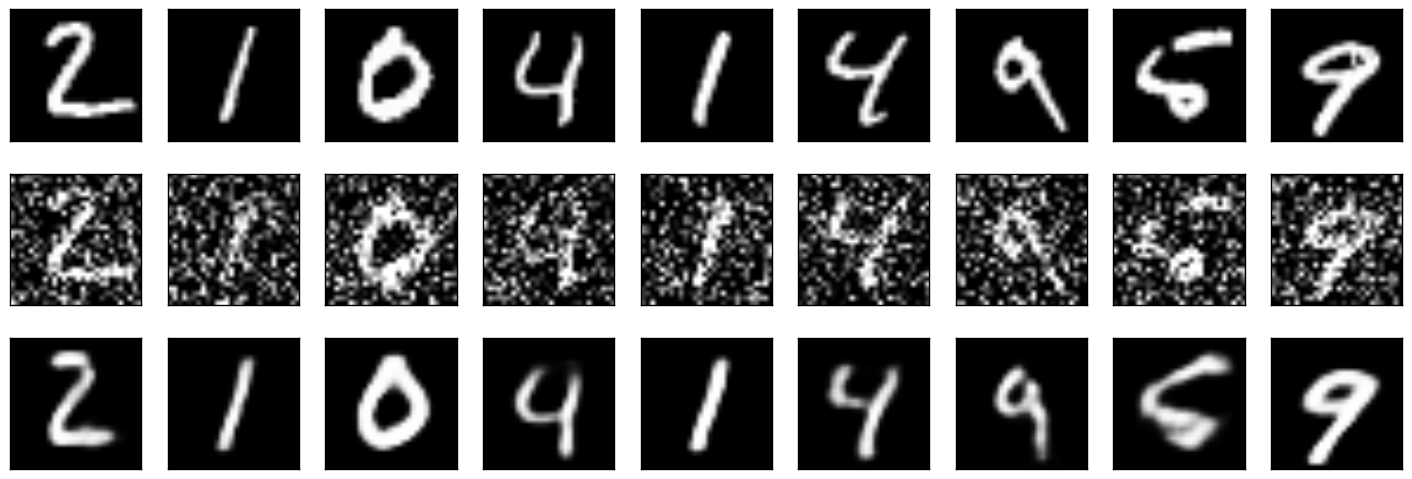

In [26]:
decoded_imgs = model.predict(x_test)
n = 10
plt.figure(figsize=(20, 6))
for i in range(1, n):
    # display original
    ax = plt.subplot(3, n, i)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display noisy
    ax = plt.subplot(3, n, i + n)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(3, n, i + 2*n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Variational Autoencoders

A variational autoencoder is an autoencoder that adds probabilistic constraints on the representations being learned. 

> When using probabilistic models, **compressed representation** is called **latent variable model**. 

So, instead of learning a function this model is learning a probabilistic distribution function that models your data.

> Why? Standard autoencoders are not suited to work as a generative model. If you pick a random value for your decoder you won't get necessarily a good reconstruction: the value can far away from any previous value the network has seen before! That's why attaching a probabilistic model to the compressed representation is a good idea! 

For sake of simplicity, let's use a standard normal distribution to define the distribution of inputs ($\mathbf V$) the decoder will receive. 

The architecture of a variational autoencoder (VAE) is thus:

<center>
<img src="images/vae1.png" alt="" style="width: 300px;"/> 
(Source: http://ijdykeman.github.io/ml/2016/12/21/cvae.html)
</center>

We want the decoder to take any point taken from a standard normal distribution to return a reasonable element of our dataset:

<center>
<img src="images/vae2.png" alt="" style="width: 500px;"/> 
(Source: http://ijdykeman.github.io/ml/2016/12/21/cvae.html)
</center>

Let's consider the encoder role in this architecture. 

In a traditional autoencoder, the encoder model takes a sample from data and returns a single point in the latent space, which is then passed to the decoder.

> What information is encoded in the latent space?

In VAE the encoder instead produces (the parameters of) a probability distribution in the latent space:

<center>
<img src="images/vae3.png" alt="" style="width: 500px;"/> 
(Source: http://ijdykeman.github.io/ml/2016/12/21/cvae.html)
</center>

These distributions are (non standard) Gaussians of the same dimensionality as the latent space. 

First, let’s implement the encoder net, which takes input $X$ and outputs two things: $\mu(X)$ and $\Sigma(X)$, the parameters of the Gaussian. Our encoder will be a neural net with one hidden layer. 

Our latent variable is two dimensional, so that we could easily visualize it.

In [35]:
# vae architecture

from tensorflow.examples.tutorials.mnist import input_data
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras.objectives import binary_crossentropy
from keras.callbacks import LearningRateScheduler

import numpy as np
import matplotlib.pyplot as plt
import keras.backend as K
import tensorflow as tf

m = 50
n_z = 2
n_epoch = 100

# encoder
inputs = Input(shape=(784,))
h_q = Dense(512, activation='relu')(inputs)
mu = Dense(n_z, activation='linear')(h_q)
log_sigma = Dense(n_z, activation='linear')(h_q)

Up to now we have an encoder that takes images and produce (the parameters of) a pdf in the latent space.  The decoder takes points in the latent space and return reconstructions.

How do we connect both models? By sampling from the produced distribution!


<center>
<img src="images/vae4.png" alt="" style="width: 400px;"/> 
(Source: http://ijdykeman.github.io/ml/2016/12/21/cvae.html)
</center>

To this end we will implement a *random variate reparameterisation*: the substitution of a random variable by a deterministic transformation of a simpler random variable.

There are several methods by which non-uniform random numbers, or random variates, can be generated. The most popular methods are the **one-liners**, which give us the simple tools to generate random variates in one line of code, following the classic paper by Luc Devroye (Luc Devroye, Random variate generation in one line of code, Proceedings of the 28th conference on Winter simulation, 1996).

In the case of a Gaussian, we can use the following algorithm:
+ Generate $\epsilon \sim \mathcal{N}(0;1)$.
+ Compute a sample from $\mathcal{N}(\mu; RR^T)$ as $\mu + R \epsilon$.

In [ ]:
def sample_z(args):
    mu, log_sigma = args
    eps = K.random_normal(shape=(m, n_z), mean=0., std=1.)
    return mu + K.exp(log_sigma / 2) * eps

# Sample z
z = Lambda(sample_z)([mu, log_sigma])

Now we can create the decoder net:

In [37]:
decoder_hidden = Dense(512, activation='relu')
h_p = decoder_hidden(z)

decoder_out = Dense(784, activation='sigmoid')
outputs = decoder_out(h_p)

Lastly, from this model, we can do three things: reconstruct inputs, encode inputs into latent variables, and generate data from latent variable. 

In [38]:
# Overall VAE model, for reconstruction and training
vae = Model(inputs, outputs)

# Encoder model, to encode input into latent variable
# We use the mean as the output as it is the center point, the representative of the gaussian
encoder = Model(inputs, mu)

# Generator model, generate new data given latent variable z
d_in = Input(shape=(n_z,))
d_h = decoder_hidden(d_in)
d_out = decoder_out(d_h)
decoder = Model(d_in, d_out)

In order to be coherent with our previous definitions, we must assure that points sampled fron the latent space fit a standard normal distribition, but the encoder is producing non standard normal distributions. So, we must add a constraint for getting something like this:

<center>
<img src="images/vae5.png" alt="" style="width: 700px;"/> 
(Source: http://ijdykeman.github.io/ml/2016/12/21/cvae.html)
</center>

In order to impose this constraint in the loss function by using the Kullback-Leibler divergence.

> The Kullback–Leibler divergence is a measure of how one probability distribution diverges from a second expected probability distribution. 
For discrete probability distributions $P$ and $Q$, the Kullback–Leibler divergence from $Q$ to $P$ is defined to be
$$ D_{\mathrm {KL} }(P\|Q)=\sum _{i}P(i)\,\log {\frac {P(i)}{Q(i)}}. $$

The rest of the loss function must take into account the "reconstruction" error.

In [39]:
def vae_loss(y_true, y_pred):
    """ 
    Calculate loss = reconstruction loss + 
    KL loss for each data in minibatch 
    """
    recon = K.sum(K.binary_crossentropy(y_pred, y_true), axis=1)
    # D_KL(Q(z|X) || P(z|X)); 
    # calculate in closed form as both dist. are Gaussian
    kl = 0.5 * K.sum(K.exp(log_sigma) + K.square(mu) 
                     - 1. - log_sigma, axis=1)
    return recon + kl

### Training a VAE

How do we train a model that have a sampling step? 

<center>
<img src="images/vae_sampling.png" alt="" style="width: 800px;"/> 
</center>

In fact this is not a problem! By using the *one-liner* method for sampling we have expressed the latent distribution in a way that its parameters are factored out of the parameters of the random variable so that backpropagation can be used to find the optimal parameters of the latent distribution. For this reason this method is called *reparametrization trick*.

By using this trick we can train end-to-end a VAE with backpropagation.

In [40]:
from keras.datasets import mnist

(x_train, _), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 784))
x_test = np.reshape(x_test, (len(x_test), 784))

vae.compile(optimizer='adam', loss=vae_loss)
vae.fit(x_train, x_train, batch_size=m, nb_epoch=n_epoch)

Epoch 1/100
60000/60000 [==============================] - 19s - loss: 181.1754    
Epoch 2/100
60000/60000 [==============================] - 20s - loss: 164.1534    
Epoch 3/100
60000/60000 [==============================] - 20s - loss: 161.2699    
Epoch 4/100
60000/60000 [==============================] - 20s - loss: 159.3786    
Epoch 5/100
60000/60000 [==============================] - 21s - loss: 157.9847    
Epoch 6/100
60000/60000 [==============================] - 20s - loss: 156.8659    
Epoch 7/100
60000/60000 [==============================] - 20s - loss: 155.9391    
Epoch 8/100
60000/60000 [==============================] - 20s - loss: 155.1295    
Epoch 9/100
60000/60000 [==============================] - 20s - loss: 154.4790    
Epoch 10/100
60000/60000 [==============================] - 20s - loss: 153.8685    
Epoch 11/100
60000/60000 [==============================] - 20s - loss: 153.3425    
Epoch 12/100
60000/60000 [==============================] - 20s - loss: 15

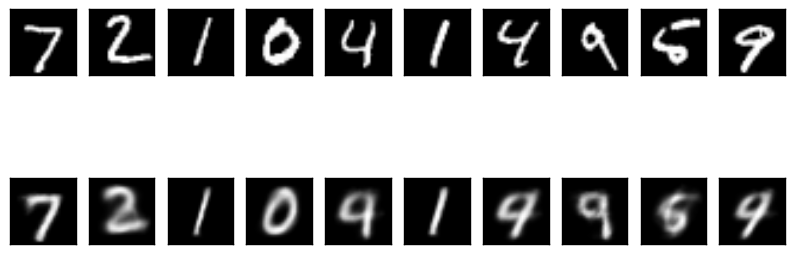

In [41]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

import matplotlib.pyplot as plt
%matplotlib inline

n = 10  # how many digits we will display
plt.figure(figsize=(10, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

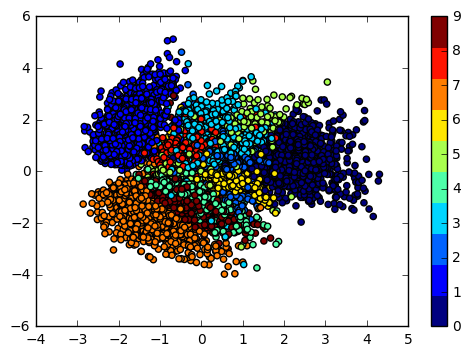

In [43]:
plt.scatter(encoded_imgs[:,0], encoded_imgs[:,1], c=y_test, cmap=plt.cm.get_cmap("jet", 10))
plt.colorbar(ticks=range(10))

### Conditional VAE

What about producing specific number instances on demand?

We can do this by adding an extra input (as a one-hot encoding) to both the encoder and the decoder:

<center>
<img src="images/vae6.png" alt="" style="width: 400px;"/> 
(Source: http://ijdykeman.github.io/ml/2016/12/21/cvae.html)
</center>

To generate an image of a particular number just feed that number in the decoder along with a random point in the latent space.

<center>
<img src="images/vae7.png" alt="" style="width: 600px;"/> 
(Source: http://ijdykeman.github.io/ml/2016/12/21/cvae.html)
</center>

The latent space is no longer encoding what number are you dealing with (because this is already encoded in the extra input!). Instead, it is encoding information such as stroke width, angle, etc.

## Bibliography

+ Doersch, Carl. “Tutorial on variational autoencoders.” arXiv preprint arXiv:1606.05908 (2016).
+ Kingma, Diederik P., and Max Welling. “Auto-encoding variational bayes.” arXiv preprint arXiv:1312.6114 (2013).